In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
import sklearn
import xlrd
import nltk as nltk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from os import path
from PIL import Image

Loading Data...
Data Loaded
Tokenizing...
Tokenization Completed
Training...
Epoch 1/13
13985/13985 [==============================] - 48s 3ms/step - loss: 0.6612 - acc: 0.6014
Epoch 2/13
13985/13985 [==============================] - 47s 3ms/step - loss: 0.5755 - acc: 0.6995
Epoch 3/13
13985/13985 [==============================] - 62s 4ms/step - loss: 0.5347 - acc: 0.7330
Epoch 4/13
13985/13985 [==============================] - 54s 4ms/step - loss: 0.5063 - acc: 0.7533
Epoch 5/13
13985/13985 [==============================] - 56s 4ms/step - loss: 0.4715 - acc: 0.7749
Epoch 6/13
13985/13985 [==============================] - 54s 4ms/step - loss: 0.4476 - acc: 0.7934
Epoch 7/13
13985/13985 [==============================] - 42s 3ms/step - loss: 0.4308 - acc: 0.8039
Epoch 8/13
13985/13985 [==============================] - 43s 3ms/step - loss: 0.4112 - acc: 0.8165
Epoch 9/13
13985/13985 [==============================] - 44s 3ms/step - loss: 0.4092 - acc: 0.8154
Epoch 10/13
13985/13985

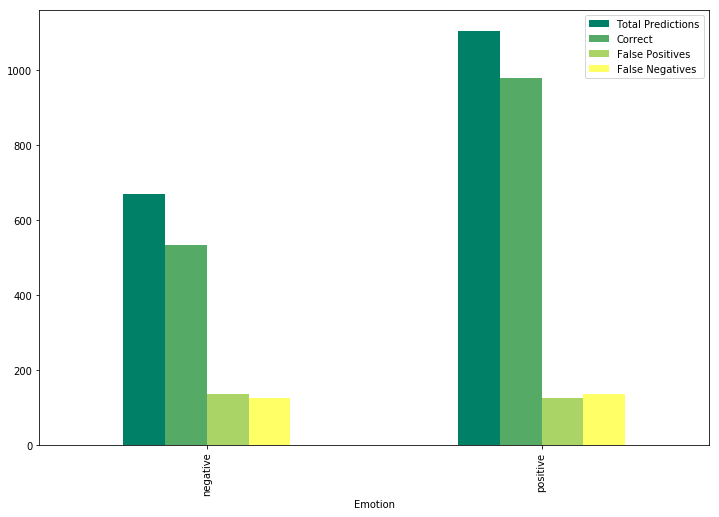

In [22]:
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets
import pandas as pd
import spacy
from spacy.util import minibatch, compounding
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from numpy import array, unique, array_equal
import keras
max_fatures = 3500
from keras import regularizers


def load_data():
    print("Loading Data...")
    TwitterEmotion = pd.read_csv('text_emotion.csv')
    print("Data Loaded")
    return (TwitterEmotion['content'], array(TwitterEmotion['sentiment']))


#Below the data is sorted into nine emotion groups. Eight of the groups are the outter layer of the wheel, or the combinations of 
#two emotion groups. The ninth group is "Ambiguous" and "Neutral" put together.
def sort_to_2_emotions(sentence_list, emotion_list):
    sorted_list = []
    sorted_emo = []
    for (data, emo) in zip(sentence_list, emotion_list):
        if (emo == 'enthusiam' or emo == 'love' or emo == 'happiness'):
            sorted_list.append(data)
            sorted_emo.append("positive")
        if (emo == 'sadness' or emo == 'hate'):
            sorted_list.append(data)
            sorted_emo.append("negative")
    return (sorted_list, sorted_emo)



def tokenize(sentences):
    print("Tokenizing...")
    tokenizer = Tokenizer(num_words=max_fatures, split=' ',lower=True)
    tokenizer.fit_on_texts(sentences)
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X)
    print("Tokenization Completed")
    return X



def train(tokened_sentences, emotion_list):
    print("Training...")
    embed_dim = 128
    lstm_out = 196
    test_percent=.1

    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = tokened_sentences.shape[1]))
    model.add(SpatialDropout1D(0.7))
    model.add(keras.layers.Dropout(.6))

    model.add(LSTM(lstm_out, dropout=0.65, recurrent_dropout=0.65))
    
    # len(set(emotion_list)) is a hacky way of geting the number of unique elements
    # in a regualar python list (non-numpy)
    model.add(Dense(unique(emotion_list).size,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True ),metrics = ['accuracy'])
    #print(model.summary())

    Y = pd.get_dummies(emotion_list).values
    X_train, X_test, Y_train, Y_test = train_test_split(tokened_sentences,Y, test_size = test_percent, random_state = 152321326)
    #print(X_train.shape,Y_train.shape)
    #print(X_test.shape,Y_test.shape)

    batch_size = 32
    model.fit(X_train, Y_train, epochs = 13, batch_size=batch_size, verbose = 1,validation_split=.0)
    print("Training Completed")
    print("Testing Against Control... (% of the data) ", test_percent)
    score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
    print("Score   :", score)
    print("Accuracy:", acc)
    return (model, X_test)

### When Splitting data (train_test_split), we don't retain where in the 
### origional set the data is located, thus it takes
### a little trickery to see the results while while only testing against untrained data
### top_predictions variable changes how many predictions given
def test(model, X_test, tokenized_data, sentence_list, emotion_list, top_predictions=1):
    predictions = model.predict(tokenized_data, batch_size=32)
    error = 0
    for i in range(len(predictions)):
     
        #  "If the current tokenized data array is in X_test (untrained tokenized arrays)
        
        if(any(array_equal(tokenized_data[i], x) for x in X_test)):
            print("\n\n")

            
            pos = list(predictions[i]).index(max(predictions[i]))
            if (unique(emotion_list)[pos] != emotion_list[i]):
                error += 1
            temp = predictions[i]
            
            print(sentence_list[i])

            for j in range(top_predictions):
                pos = list(temp).index(max(temp))
                print("\n # %s Predicted emotion : ",j+1, unique(emotion_list)[pos])
                temp[pos] = 0
            print("Actual emotion   : ", emotion_list[i])

    print("%  Accuracy when against untrained set: ", 1- (float(error) / len(X_test)))

def count_errors(model, tokenized_data, sentence_list, emotion_list, X_test):
    dims =  len(unique(emotion_list))
    mistake_list = np.zeros((dims,dims), dtype=np.int)
    predictions = model.predict(tokenized_data, batch_size=32)
    print("Total predictions:", len(predictions))
    for i in range(len(predictions)):
        if(any(array_equal(tokenized_data[i], x) for x in X_test)):
            pos = list(predictions[i]).index(max(predictions[i]))
            mistake_list[list(unique(emotion_list)).index(emotion_list[i])][pos] += 1
   # for i in range(len(mistake_list)):
   #     for j in range(len(mistake_list)):
   #         mistake_list[i][j] = mistake_list[i][j] * 100 / list(emotion_list).count(unique(emotion_list)[i]) 
    print(mistake_list)
    return mistake_list


def graph_errors(mistake_list, emotion_list):
    dim = len(mistake_list[0])
    
    false =  np.zeros((dim,4), dtype=np.int)
    
    #total number of testing data for each category
    for i in range(dim):
        for j in range(dim):
            false[i][0] += mistake_list[i][j]

    
    #true positives
    for i in range(dim):
              false[i][1] = mistake_list[i][i]
    #false positives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[i][j]
        false[i][2] = sum
   #     
  #          #false Negatives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[j][i]
        false[i][3] = sum
    df = pd.DataFrame(false)
    #, "False Positives", "False Negatives"
    
    df.columns = ["Total Predictions", "Correct","False Positives","False Negatives"]
    df.insert(0, "Emotion", np.unique(emotion_list))
    (_, counts) = np.unique(emotion_list,return_counts=True)
   # for i in range(counts.size):
   #     counts[i] = counts[i] / 60
   # df.insert(1,"Amount of Data / 10",counts)
    print(df.to_latex())
    df.plot.bar(x='Emotion',figsize=(12,8),colormap=cm.get_cmap('summer'))
    #plot = sns.barplot(x="Emotion",y=Correct, data=df)




#################################
#############MAIN################
#################################
#   jupyter notebook is weird   #




(sentence_list, emotion_list) = load_data()


### Comment the Below line for all 18 emotions. This sorts into "positive" and "negative"
sentence_list, emotion_list = sort_to_2_emotions(sentence_list, emotion_list)

tokenized_data = tokenize(sentence_list)

(model, X_test) = train(tokenized_data, emotion_list)

#test(model, X_test, tokenized_data, sentence_list, emotion_list)

mistake_list = count_errors(model, tokenized_data, sentence_list, emotion_list,X_test)

graph_errors(mistake_list, emotion_list)


    Emotion  Correct  Emotions in Category
0  negative     4858                  6488
1  positive     8161                  9051


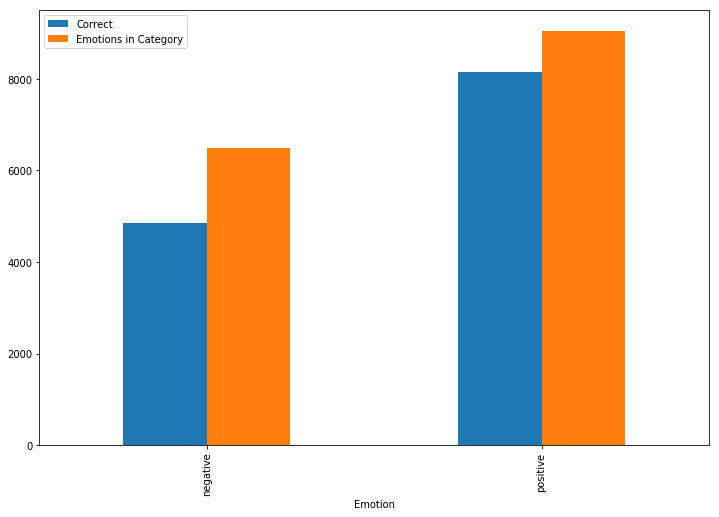

In [14]:
# fig = plt.figure(figsize=(20,4))
#sns.barplot(x = ProjectData['emotion'].unique(), y=ProjectData['emotion'].value_counts())
#plt.show()
from matplotlib import cm
graph_errors(mistake_list, emotion_list)
